# Co2 Decoupling

## Setting up Enviorment

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, root_mean_squared_error
import joblib as jb

In [2]:
import os
os.chdir(os.path.expanduser("C:\\Users\\Nico\\Desktop\\Personal Projects Data Science\\Co2 predictions"))

from co2mdl import TrainModel, TrainSVR

In [3]:
#read in
df_all_raw = pd.read_csv('owid-co2-data.csv')
pop_raw = pd.read_csv('PopPrediction.csv')

In [4]:
#filtering
df_all = df_all_raw[df_all_raw['gdp'].isnull() == False]
df_all = df_all[df_all['co2'].isnull() == False]
df_all['gdp_per_capita'] = df_all['gdp']/df_all['population']

df_co2 = df_all[['iso_code','year','population','gdp','gdp_per_capita','co2']]

In [5]:
#filtering
pop = pop_raw[['location_name','year_id','scenario_name','val']]
pop = pop[pop['scenario_name'] == 'Reference'][['location_name','year_id','val']]
pop.columns = ['country', 'year','population']
pop = pop[pop['year'] >= 2023]

## Splitting apart the DataFrames

The goal here is to further clean the data sets specifically mathching data between the population and co2 data

In [6]:
isocodes = df_co2['iso_code'].unique() #getting all the iso codes with co2 data
isocodes = isocodes[~pd.isnull(isocodes)] #dropping all null iso codes (ie Africa, World, etc)
isocodes = np.delete(isocodes, np.where(isocodes == 'HKG')) #Hong Kong does not have populations prediction data

In [7]:
to_iso = df_all[['country','iso_code']].drop_duplicates() #creating a data frame to translate iso codes to country

In [8]:
#standardizing the names of all the countries

fixed = []

for i in isocodes:
    #getting the popultion prediction dataframe
    #if pops is empty, then there is a country name mismatch
    locate = to_iso[to_iso['iso_code'] == i]
    country = locate['country'].loc[locate.index[0]]
    pops = pop[pop['country'] == country][['year','population']]
    
    if len(pops) == 0:
        #finding all the mismatches
        app = to_iso[to_iso['iso_code'] == i]
        app = app['country'].loc[app.index[0]]
        fixed.append(app)

correct = ['Bolivia (Plurinational State of)','Cabo Verde',"Côte d'Ivoire",'Democratic Republic of the Congo',
          'Iran (Islamic Republic of)',"Lao People's Democratic Republic",'Republic of Moldova',
          "Democratic People's Republic of Korea",'Russian Federation','Republic of Korea','Syrian Arab Republic',
          'Taiwan (Province of China)','United Republic of Tanzania','United States of America',
          'Venezuela (Bolivarian Republic of)','Viet Nam']

#correcting all the mismatches
for i in range(len(fixed)):
    pop.loc[pop['country'] == correct[i], 'country'] = fixed[i]

## GDP Models

We will train the GDP models and predict future GDP using those models

In [9]:
#training the gdp models, all of these are done through polygraphs
'''
gdpmodels = {}

for i in isocodes:
    dftemp = df_co2[df_co2['iso_code'] == i] #getting all data related to once specific country
    
    #initializing model
    modelgdp_int = LinearRegression()
    polygdp_int = PolynomialFeatures(degree=2)
    
    #splitting into features and target data
    Xgdp = dftemp[['year','population']]
    ygdp = dftemp['gdp']
    
    #training the model
    gdpModel = TrainModel(modelgdp_int, polygdp_int, Xgdp, ygdp, threshold=0.65)
    
    modelgdp, polygdp, refgdp, gdp_target, gdp_test, gdp_test_data = gdpModel
    
    #saving it to the dictionary defined above
    gdpmodels[i] = [modelgdp,polygdp,gdp_test[0], gdp_test_data]
'''
gdpmodels = jb.load('Decouple\\Decoup GDP Models')

In [10]:
#predicting future gdp based on the gdp models
pred_gdp = {}
neg = [] #looking for models that produce negative gdp at any point
bad = [] #looking for models with bad r2 scores

for i in isocodes:
    #matching country to iso code to get pop prediction
    locate = to_iso[to_iso['iso_code'] == i]
    country = locate['country'].loc[locate.index[0]]
    pops = pop[pop['country'] == country][['year','population']]
    
    #unpacking and using the model to predict
    modelgdp, polygdp, r2, test = gdpmodels[i]
    X_poly = polygdp.transform(pops)
    y_pred = modelgdp.predict(X_poly)
    
    #looking for negatives
    for j in y_pred:
        if j < 0:
            neg.append(i)
            break
            
    #looking for bad r2
    if r2 < 0.70:
        bad.append(i)
    
    #save the predictions in the dictionary above
    pred_gdp[i] = [pops['year'], y_pred, r2, test]

#get rid of the bad predictions
for i in neg:
    pred_gdp.pop(i)
    
for i in bad:
    try:
        pred_gdp.pop(i)
    except KeyError:
        continue

## CO2 Models

Train the CO2 models by splitting them into svr or poly regressions first, then training the appropriate model. Will also predict future CO2 using those models

In [11]:
#Dividing into what kind of plot to train the data on
svrplt = [] #SVR works better when the co2 emissions are trending down at the end to the data set
polyplt = [] #linear regressions work better when the data is trending up at the end of the data set
keys = list(pred_gdp.keys())

for i in keys:
    co2temp = df_co2[df_co2['iso_code'] == i]['co2'] #gets co2 data for the country
    
    last = co2temp.iloc[-10:]#gets last 10 points in the co2 data
    
    if all(co2temp.max() > val for val in last): #if the the max co2 emission is not here, it is 'trending down'
        svrplt.append(i)
        
    else:
        polyplt.append(i)

In [12]:
#training the linear regression models first
'''
co2models = {}

for i in polyplt:
    #relevent data for a specific country
    dftemp = df_co2[df_co2['iso_code'] == i]
    
    #initialize model
    modelco2_int = LinearRegression()
    polyco2_int = PolynomialFeatures(degree=1)
    
    #features and target
    Xco2 = dftemp[['year','population','gdp','gdp_per_capita']]
    yco2 = dftemp['co2']
    
    #Trian the model
    co2Model = TrainModel(modelco2_int,polyco2_int,Xco2,yco2,threshold=0.9)
    
    modelco2, polyco2, refco2, co2_target, co2_test, co2_test_data = co2Model
    
    #put model in the dictionary
    co2models[i] = [modelco2,polyco2,co2_test[0], co2_test_data]
'''

"\nco2models = {}\n\nfor i in polyplt:\n    #relevent data for a specific country\n    dftemp = df_co2[df_co2['iso_code'] == i]\n    \n    #initialize model\n    modelco2_int = LinearRegression()\n    polyco2_int = PolynomialFeatures(degree=1)\n    \n    #features and target\n    Xco2 = dftemp[['year','population','gdp','gdp_per_capita']]\n    yco2 = dftemp['co2']\n    \n    #Trian the model\n    co2Model = TrainModel(modelco2_int,polyco2_int,Xco2,yco2,threshold=0.9)\n    \n    modelco2, polyco2, refco2, co2_target, co2_test, co2_test_data = co2Model\n    \n    #put model in the dictionary\n    co2models[i] = [modelco2,polyco2,co2_test[0], co2_test_data]\n"

In [13]:
'''
for i in svrplt:
    #relevent data
    dftemp = df_co2[df_co2['iso_code'] == i]
    
    #features and target data
    Xco2 = dftemp[['year','population','gdp','gdp_per_capita']]
    yco2 = dftemp['co2']
    
    #identifying the best c value for the svr model
    validation = []
    c_vals = np.array(range(100,180))

    for j in c_vals:
        modelco2_tst = SVR(C=(j+1))
        co2Model_tst = TrainSVR(modelco2_tst, Xco2, yco2)
        modelco2, refco2, co2_target, co2_test, co2_test_data = co2Model_tst
        validation.append(co2_test[0])

    validation = np.array(validation)
    
    if validation[validation.argmax()] > 0.8: #check to see if the model is good enough to use
        
        #train the best model
        modelco2_int = SVR(C=validation.argmax()+1)
        
        co2Model = TrainSVR(modelco2_tst, Xco2, yco2)
        modelco2, refco2, co2_target, co2_test, co2_test_data = co2Model
    
    #put the model into the dictionary
    co2models[i] = [modelco2,co2_test[0],co2_test_data]
'''
co2models = jb.load('Decouple\\Decoup Co2 Models')

In [21]:
#make predictions off of the co2 models
pred_co2 = {}

co2keys = list(co2models.keys())

for i in co2keys:
    #matching iso codes to the country and getting pop predictions
    locate = to_iso[to_iso['iso_code'] == i]
    country = locate['country'].loc[locate.index[0]]
    fut = pop[pop['country'] == country][['year','population']]
    
    #building in the gdp per capita feature
    fut['gdp'] = pred_gdp[i][1]
    fut['gdp_per_capita'] = fut['gdp']/fut['population']
    
    #making the prediction
    #the svr and poly models have different parameters so a svr model will put out a value error
    try:
        modelco2, polyco2, r2, test = co2models[i]
        X_poly = polyco2.transform(fut)
        y_pred = modelco2.predict(X_poly)
    except ValueError:
        modelco2, r2, test = co2models[i]
        y_pred = modelco2.predict(fut)
    
    #put the prediction into the dictionary
    pred_co2[i] = [fut['year'],fut['gdp_per_capita'], fut['gdp'], y_pred, r2]
    

## Finding the median value
This is the final step, and ultimate goal, of this project. We will find what the median decoupling GDP per capita will be.

In [15]:
#combing all the predicted data with the data we already have
comb_co2 = {}
comb_gdp_per_capita = {}
comb_gdp = {}
years = {}

for i in co2keys:
    dftemp = df_co2[df_co2['iso_code'] == i]
    
    #using lists to concatonate, then changin to a numpy array
    #adding each combination to the respective dictionary
    comb_co2[i] = np.array(list(dftemp['co2']) + list(pred_co2[i][3]))
    years[i] = np.array(list(dftemp['year']) + list(pred_co2[i][0]))
    comb_gdp_per_capita[i] = np.array(list(dftemp['gdp_per_capita']) + list(pred_co2[i][1]))
    comb_gdp[i] = np.array(list(dftemp['gdp']) + list(pred_gdp[i][1]))

In [16]:
#using the combined data to identify the peak of the predicted co2 curve 
peak_co2 = []

for i in co2keys:
    #finding the max value in the combined co2 array
    peak_co2.append(comb_gdp_per_capita[i][comb_co2[i].argmax()])

#convert to numpy array
peak_co2 = np.array(peak_co2)

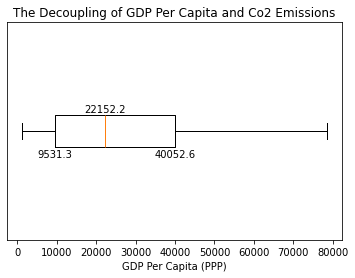

In [17]:
#Plotting data in a boxplot
fig, axs = plt.subplots()

box = plt.boxplot(peak_co2, sym='',vert=False) #build the box plot, with no outliers
axs.set_xlabel('GDP Per Capita (PPP)') #x label
axs.set_title('The Decoupling of GDP Per Capita and Co2 Emissions')#title
axs.set(yticklabels=[])
axs.tick_params(left=False)

#displaying the median line value
x, y = box['medians'][0].get_xydata()[1]
plt.text(x, 1.085, '%.1f' % x,horizontalalignment='center')

#Displaying Q1 and Q2 values
x1, y1 = box['boxes'][0].get_xydata()[0] # bottom of left line
plt.text(x1, 0.915, '%.1f' % x1, horizontalalignment='center', verticalalignment='top')
x2, y2 = box['boxes'][0].get_xydata()[3] # bottom of right line
plt.text(x2, 0.915, '%.1f' % x2, horizontalalignment='center', verticalalignment='top')

plt.show()
#fig.savefig('DecoupleCo2.jpeg')